In [10]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# load file (put laptopData.csv in same folder)
df = pd.read_csv("F:laptopData.csv")
print("Initial shape:", df.shape)
df.head()


Initial shape: (1303, 12)


,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [11]:
# 2) Quick checks
print(df.columns.tolist())
print("Price dtype:", df['Price'].dtype)
print("Missing values (top cols):")
print(df[['Company','Ram','Memory','Weight','Price']].isnull().sum())


['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price']
Price dtype: float64
Missing values (top cols):
Company    30
Ram        30
Memory     30
Weight     30
Price      30
dtype: int64


In [12]:
# 3) Simple cleaning / numeric conversions
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Make sure Price numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# RAM -> numeric GB
df['Ram_GB'] = pd.to_numeric(df['Ram'].astype(str).str.replace('GB','', regex=False), errors='coerce')

# Weight -> numeric kg
df['Weight_kg'] = pd.to_numeric(df['Weight'].astype(str).str.replace('kg','', regex=False), errors='coerce')

# Inches -> numeric
df['Inches'] = pd.to_numeric(df['Inches'], errors='coerce')

# Memory: parse total GB (handles "128GB SSD + 1TB HDD")
def parse_memory_total_gb(x):
    if pd.isna(x): return np.nan
    s = str(x)
    parts = re.findall(r'(\d+)\s*(TB|GB)', s, flags=re.I)
    total = 0.0
    for num, unit in parts:
        n = float(num)
        if unit.lower().startswith('t'):
            total += n * 1024.0
        else:
            total += n
    return total if total>0 else np.nan

df['Memory_GB'] = df['Memory'].apply(parse_memory_total_gb)

# Small engineered categorical features
df['CPU_Brand'] = df['Cpu'].astype(str).str.split().str[0].fillna('Unknown')
df['GPU_Brand'] = df['Gpu'].astype(str).str.split().str[0].fillna('Unknown')


In [13]:
# 4) Keep only rows that have Price (target must exist)
df = df[df['Price'].notna()].copy()
print("After keeping Price rows:", df.shape)

# Numeric columns we will use
num_cols = ['Ram_GB', 'Weight_kg', 'Inches', 'Memory_GB']

# Impute numeric NaNs with median (safe)
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Fill categorical NaNs with 'Unknown'
cat_cols = ['Company','TypeName','CPU_Brand','GPU_Brand','OpSys']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')


After keeping Price rows: (1273, 16)


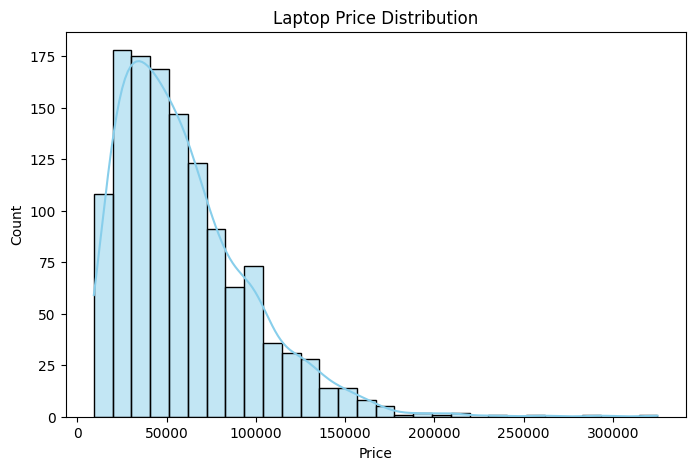

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of Laptop Prices
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], kde=True, bins=30, color="skyblue")
plt.title("Laptop Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()



C:\Users\nikit\AppData\Local\Temp\ipykernel_8028\719928320.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Company", y="Price", data=df, estimator="mean", ci=None, palette="viridis")
C:\Users\nikit\AppData\Local\Temp\ipykernel_8028\719928320.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Company", y="Price", data=df, estimator="mean", ci=None, palette="viridis")


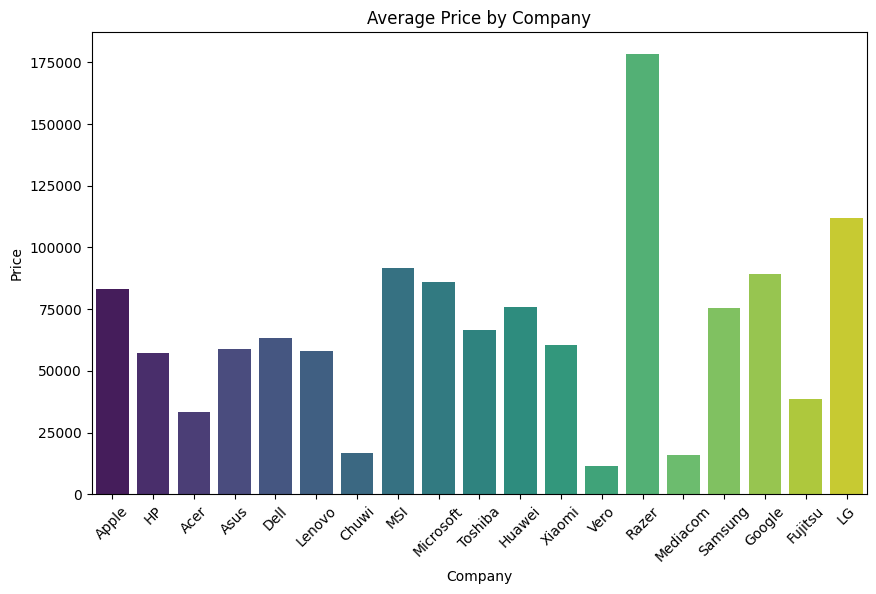

In [26]:
# 2. Average Price by Company
plt.figure(figsize=(10,6))
sns.barplot(x="Company", y="Price", data=df, estimator="mean", ci=None, palette="viridis")
plt.title("Average Price by Company")
plt.xticks(rotation=45)
plt.show()



C:\Users\nikit\AppData\Local\Temp\ipykernel_8028\3329788489.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="OpSys", y="Price", data=df, estimator="mean", ci=None, palette="coolwarm")
C:\Users\nikit\AppData\Local\Temp\ipykernel_8028\3329788489.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="OpSys", y="Price", data=df, estimator="mean", ci=None, palette="coolwarm")


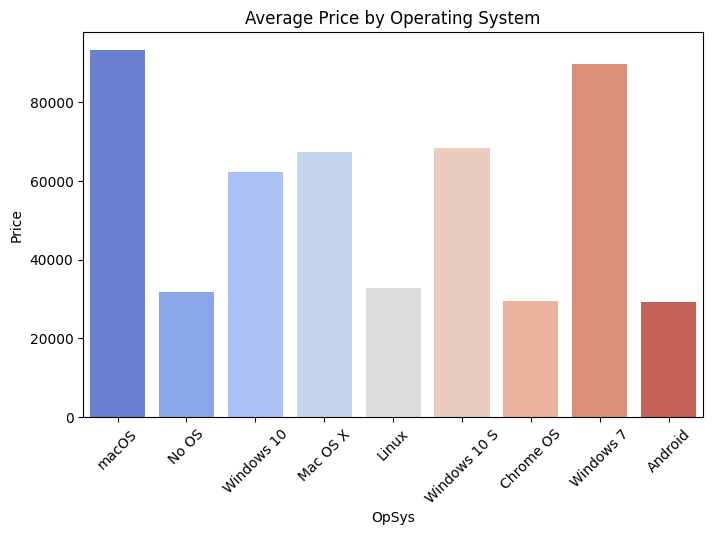

In [28]:


# . Average Price by Operating System
plt.figure(figsize=(8,5))
sns.barplot(x="OpSys", y="Price", data=df, estimator="mean", ci=None, palette="coolwarm")
plt.title("Average Price by Operating System")
plt.xticks(rotation=45)
plt.show()


In [14]:
# 5) Prepare features and target
features = num_cols + ['Company','TypeName','CPU_Brand','GPU_Brand','OpSys']

X = df[features].copy()
y = df['Price'].copy()

# Convert categorical → dummies (one-hot)
X = pd.get_dummies(X, columns=['Company','TypeName','CPU_Brand','GPU_Brand','OpSys'], drop_first=True)

print("Feature matrix shape:", X.shape)


Feature matrix shape: (1273, 40)


In [15]:
# 6) Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1018, 40) Test: (255, 40)


In [21]:
 # Feature importance (top 10)
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top10 = importances.sort_values(ascending=False).head(10)
print(top10)


Ram_GB                  0.568625
Weight_kg               0.142381
Memory_GB               0.051757
TypeName_Notebook       0.049981
Company_Razer           0.040964
Inches                  0.028830
TypeName_Workstation    0.024689
OpSys_Windows 7         0.012317
Company_Asus            0.009825
Company_HP              0.009159
dtype: float64


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

results = []

# Train & evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append((name, rmse, r2))

# Make a results table
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"])
print(results_df.sort_values(by="R2", ascending=False))


               Model          RMSE        R2
2      Random Forest  19847.892655  0.728445
1      Decision Tree  21016.513942  0.695526
0  Linear Regression  22309.658993  0.656905


| Model             | RMSE (\~₹) | R²        | Meaning                                                           |
| ----------------- | ---------- | --------- | ----------------------------------------------------------------- |
| **Random Forest** | **19,848** | **0.728** | Best performer – captures \~73% of variance, average error \~₹20k |
| Decision Tree     | 21,016     | 0.696     | Simpler but less accurate than RF                                 |
| Linear Regression | 22,309     | 0.657     | Weakest – struggles with nonlinear laptop pricing patterns        |


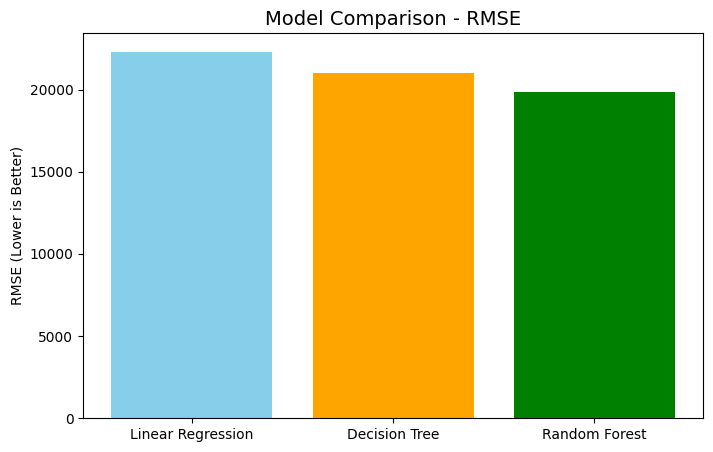

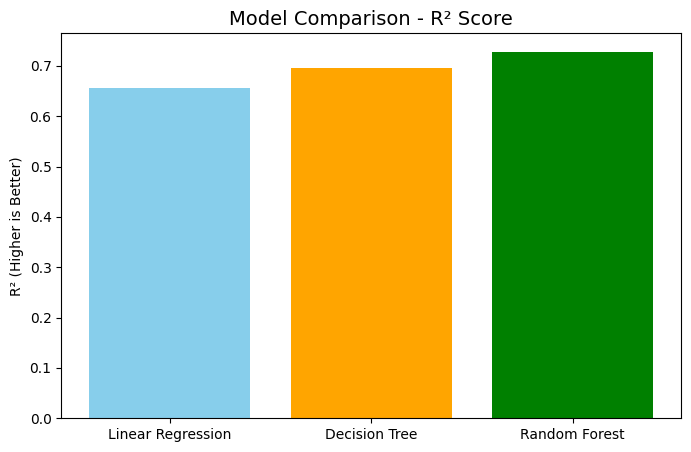

In [23]:
import matplotlib.pyplot as plt

# --- RMSE Bar Chart ---
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["RMSE"], color=["skyblue","orange","green"])
plt.title("Model Comparison - RMSE", fontsize=14)
plt.ylabel("RMSE (Lower is Better)")
plt.show()

# --- R² Bar Chart ---
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2"], color=["skyblue","orange","green"])
plt.title("Model Comparison - R² Score", fontsize=14)
plt.ylabel("R² (Higher is Better)")
plt.show()


Random Forest	19,848	0.728	Best performer – captures ~73% of variance, average error ~₹20k

📝 Conclusion

The Random Forest model outperformed Linear Regression and Decision Tree models in predicting laptop prices, achieving an R² of ~0.73 with an RMSE of ~₹19,800.

It captures the non-linear relationships between features like RAM, Company, CPU, GPU, and Screen Size, making it a reliable model for price prediction.

However, it comes with the trade-offs of being more complex, slower to train, and harder to interpret. For practical deployment, Random Forest provides a good balance between accuracy and robustness, especially for datasets like laptop specifications where multiple features interact.

🔹 Features of Random Forest

Uses an ensemble of decision trees (bagging method).

Each tree is trained on a random subset of data and features → reduces overfitting.

Can handle both classification and regression problems.

Works well with nonlinear relationships.

Provides feature importance scores.

✅ Advantages

High accuracy – usually better than single decision trees.

Reduces overfitting through averaging of multiple trees.

Works with both categorical and numerical data.

Handles missing values and outliers reasonably well.

Provides feature importance to interpret model.

❌ Disadvantages

Slower training compared to simple models (many trees need to be built).

Less interpretable than a single decision tree (harder to explain decisions).

Requires more memory and computational power.

Performance can degrade if there are too many irrelevant features.